# import the libraries

In [1]:
import os
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import tensorflow as tf
from PIL import Image
import seaborn as sns
import cv2

from tensorflow import keras
import tensorflow.keras as keras
from keras import layers
from keras.layers import GlobalAvgPool2D as GAP, Dense, Dropout
from keras.callbacks import EarlyStopping as ES, ModelCheckpoint as MC
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model

In [2]:
path = '/content/drive/MyDrive/Classification/temp/finalphotoes'

class_name = os.listdir(path)
class_length = len(class_name)

print(f"class_length : {class_length}")
print(f"class_name : {class_name}")

class_length : 8
class_name : ['Amoeba', 'Euglena', 'Hydra', 'Paramecium', 'Rod_bacteria', 'Spherical_bacteria', 'Spiral_bacteria', 'Yeast']


In [3]:
class_dis = []
for name in class_name:
  class_dis.append(len(os.listdir(path + "/" + name)))
class_dis

[1415, 2979, 1472, 2731, 1633, 1634, 1451, 1449]

In [4]:
fig = px.pie(names=class_name, values=class_dis, title='micro organism disribution')
fig.update_layout({'title':{'x':0.45}})
fig.show()

([<matplotlib.patches.Wedge at 0x7fe22634d7c0>,
 [Text(1.0505138397081146, 0.32622181499972375, 'Amoeba'),
  Text(0.3613495143699861, 1.038954536283747, 'Euglena'),
  Text(-0.6323180734593628, 0.9000965803604856, 'Hydra'),
  Text(-1.097744517849949, 0.07040577767756825, 'Paramecium'),
  Text(-0.7138766137399118, -0.8368871969120073, 'Rod_bacteria'),
  Text(-0.012171274524303737, -1.0999326616099978, 'Spherical_bacteria'),
  Text(0.661655758155347, -0.8787557440494332, 'Spiral_bacteria'),
  Text(1.0481261952220273, -0.33381353910438777, 'Yeast')])

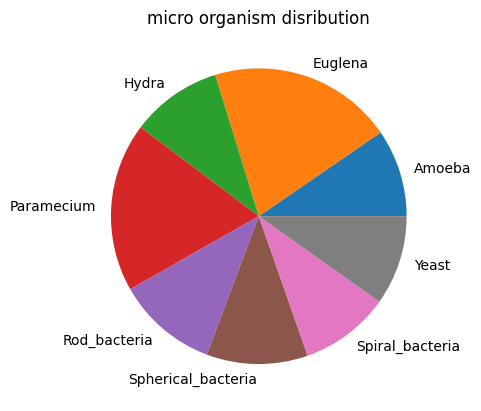

In [5]:
x = class_dis
name = class_name
plt.title("micro organism disribution")
plt.pie(x, labels = name)

In [6]:
# Now we will plot barchart
fig = px.bar(x=class_name, y=class_dis, title="Class Distribution")
fig.update_layout({'title':{'x':0.45}})
fig.show()

<BarContainer object of 8 artists>

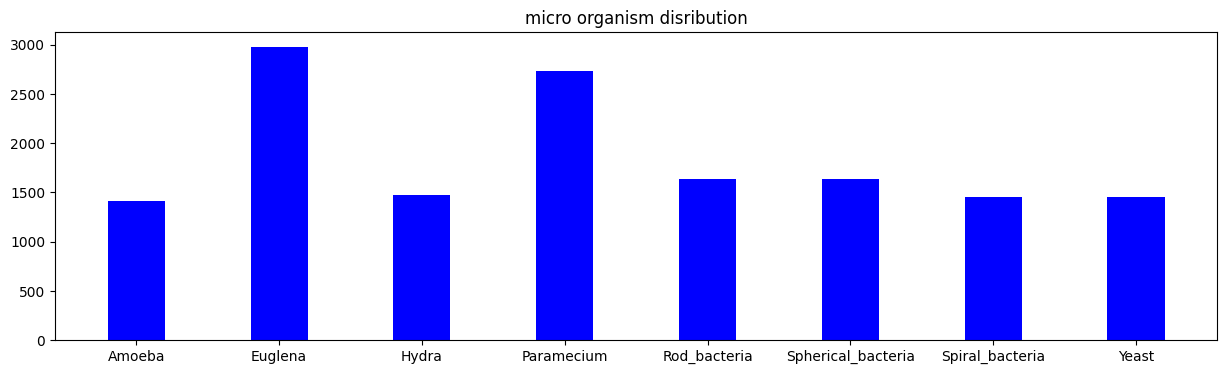

In [7]:
plt.figure(figsize=(15,4))
plt.title("micro organism disribution")
plt.bar(name, class_dis, color ='blue',width = 0.4)

<p>->
Here all the categories has not equal destribution of data. This can be lead the model training in the bised on highly populated categories. So we have to fix it.<br>->
We will use Image data generator to fix it. 
</p>

# Data Augmantation

In [8]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    horizontal_flip=True,
    brightness_range=[0.3,0.8],
    validation_split=0.1
)

In [9]:
train_ds = datagen.flow_from_directory(
    path,
    batch_size=512,
    shuffle=True,
    class_mode='binary',
    target_size=(256,256),
    subset='training'
)

Found 13291 images belonging to 8 classes.


In [10]:
valid_ds = datagen.flow_from_directory(
    path,
    batch_size=512,
    shuffle=True,
    class_mode='binary',
    target_size=(256,256),
    subset='validation'
)

Found 1473 images belonging to 8 classes.


# visulization of the data

In [11]:
from numpy.random.mtrand import randint
def show_images(data, GRID=[2,6], model=None, size=(23,10)):
  n_rows, n_cols = GRID
  n_images = n_rows * n_cols
  plt.figure(figsize=size)
  
  images, labels = next(iter(data))

  for i in range(1, n_images+1):
    id = np.random.randint(len(images))
    image, label = images[id], class_name[int(labels[id])]

    plt.subplot(n_rows, n_cols, i)
    plt.imshow(image)
    plt.axis('off')

    if model is not None:
      pred = class_name[np.argmax(model.predict(image[np.newaxis, ...]))]
      title = f"Class : {label} \n Pred : {pred}"
      plt.title(title)
    else:
      title = f"Class : {label}"
      # title = f"{label}"
      plt.title(title)

  plt.show()

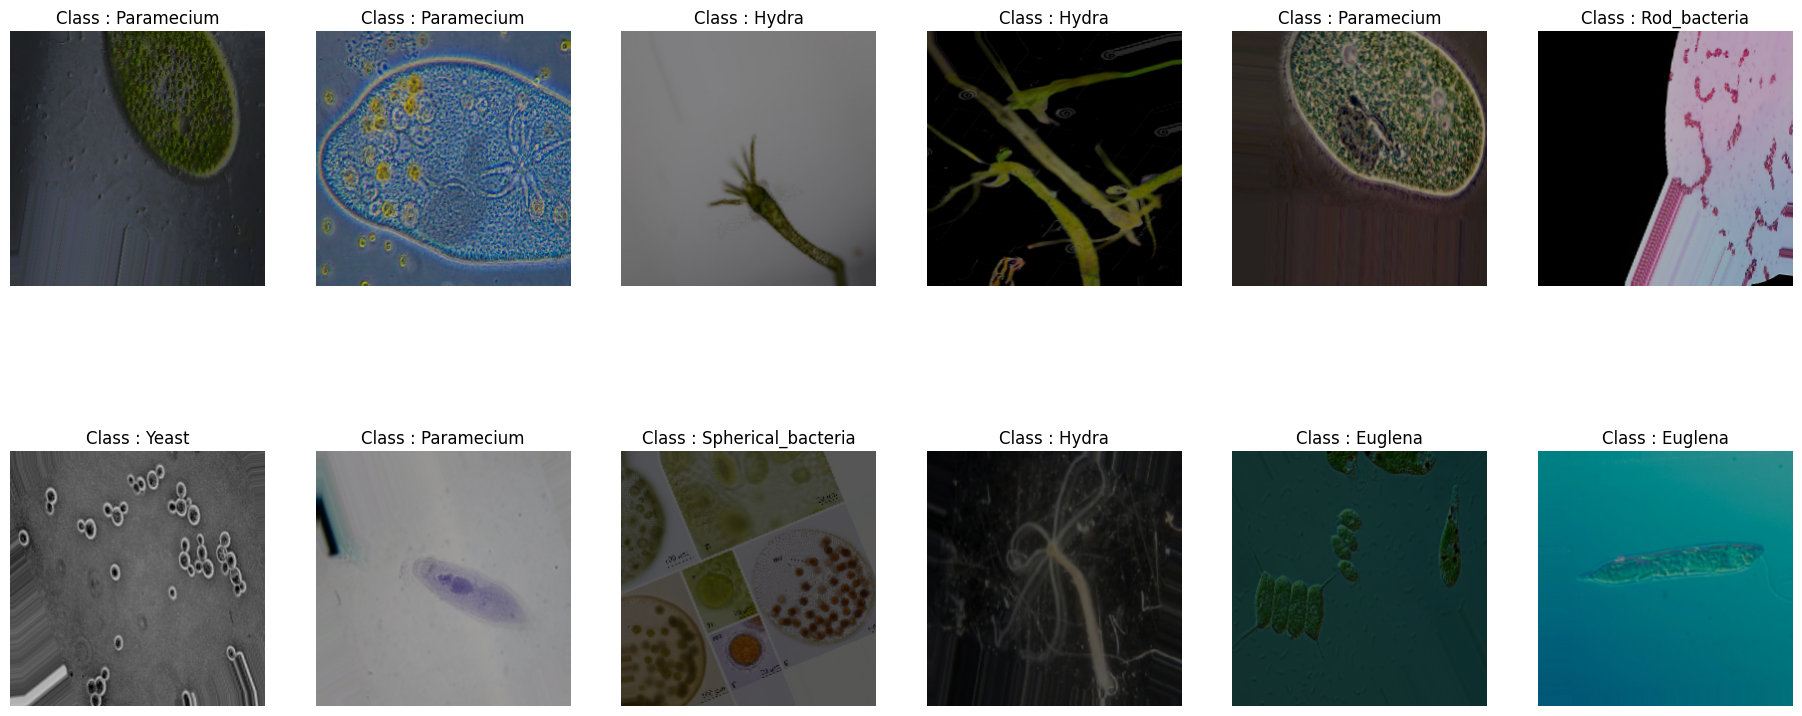

In [12]:
show_images(data=train_ds)

# creation of model

In [13]:
model_name = "inception-v3"

base = tf.keras.applications.InceptionV3(input_shape=(256,256,3), include_top=False)
base.trainable = False

87910968/87910968 [==============================] - 1s 0us/step


In [14]:
# creating model
model = Sequential([
    base,
    GAP(),
    Dense(128, kernel_initializer='he_normal', activation='relu'),
    Dropout(0.2),
    Dense(256, activation="relu", name="layer2"),
    Dropout(0.2),
    Dense(class_length, activation='softmax')
])

In [15]:
# defining callbacks
cbs = [ES(patience=3, restore_best_weights = True), MC(model_name + ".h5" , save_best_only = True)]

In [16]:
# compiling model
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [17]:
# fitting model
history = model.fit(train_ds,steps_per_epoch = len(train_ds),validation_data=valid_ds,validation_steps=len(valid_ds),epochs=10,callbacks=cbs)

Epoch 1/10
26/26 [==============================] - 2734s 104s/step - loss: 1.5233 - accuracy: 0.4513 - val_loss: 1.0362 - val_accuracy: 0.6415
Epoch 2/10
26/26 [==============================] - 393s 15s/step - loss: 0.9522 - accuracy: 0.6752 - val_loss: 0.7561 - val_accuracy: 0.7393
Epoch 3/10
26/26 [==============================] - 383s 15s/step - loss: 0.7137 - accuracy: 0.7555 - val_loss: 0.5782 - val_accuracy: 0.7936
Epoch 4/10
26/26 [==============================] - 391s 15s/step - loss: 0.5668 - accuracy: 0.8048 - val_loss: 0.4887 - val_accuracy: 0.8323
Epoch 5/10
26/26 [==============================] - 389s 15s/step - loss: 0.4696 - accuracy: 0.8379 - val_loss: 0.4121 - val_accuracy: 0.8615
Epoch 6/10
26/26 [==============================] - 382s 15s/step - loss: 0.3906 - accuracy: 0.8653 - val_loss: 0.3385 - val_accuracy: 0.8771
Epoch 7/10
26/26 [==============================] - 380s 15s/step - loss: 0.3366 - accuracy: 0.8847 - val_loss: 0.2952 - val_accuracy: 0.8955
Epoc

<h4> Here we got 89% accuracy after 10 epochs </h4>

# predictions

1/1 [==============================] - 0s 25ms/step


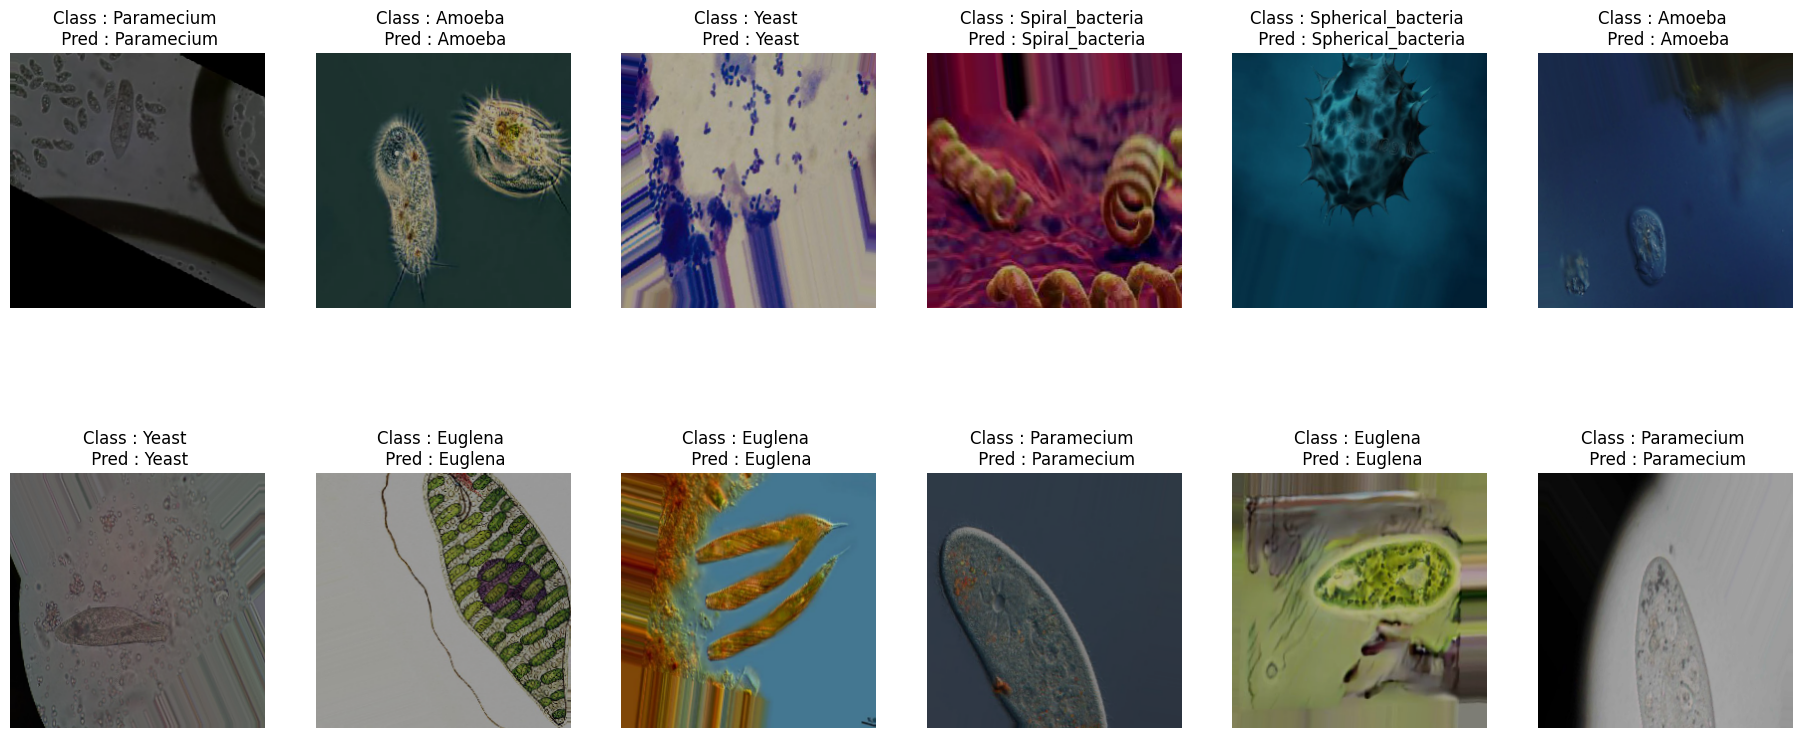

In [18]:
show_images(data=valid_ds, model=model)

In [22]:
# # Plotting graph for Accuracy and loss
# plt.plot(model.history['accuracy'])
# plt.plot(model.history['val_accuracy'])
# plt.title('Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend(['train', 'test'], loc='upper right')
# plt.show()


# plt.plot(model.history['loss'])
# plt.plot(model.history['val_loss'])
# plt.title('Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Acc')
# plt.legend(['train', 'test'], loc='lower right')
# plt.show()